# Developement of generalizable machine learning models for collaboration quality with MMLA
This notebook contains code to illustrate effect of various steps on model's performance in terms of classifying collaboration quality and its dimensions. The results of this paper will be published in LAK 2023.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import itertools
from scipy import stats
import researchpy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

from numpy import mean,nanmean
from numpy import std,nanstd

from tabulate import tabulate

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score

import seaborn as sns

We investigated following pre-processing and modeling steps
1. Effect of outlier handling on the performance 
2. Effect of scaling
3. Effect of Tuning
4. Effect of thresholding
5. Effect of contextual data

These combinations results in total 32 model development pipelines

In [1]:
outlier_handle = [True,False]
scaling =['Standard','MaxAbs']
tuning = [True,False]
thresholding = [True, False]
context_data = [True, False]

print('Pipelines')
print('-'*40)

for index, comb in enumerate(itertools.product(outlier_handle,
                                               scaling,
                                               tuning,
                                               thresholding,
                                               context_data)):

    pipeline = ''
    pipeline += 'with_context_data==>' if comb[4] else ''
    pipeline += 'outlier_handling==>' if comb[0] else ''
    pipeline +=  comb[1]
    pipeline += '==>hyper_tuning' if comb[2] else ''
    pipeline += '==>thresholding' if comb[3] else ''
    
    pipeline += '\n' if (index+1)%10 == 0 else ''
    
    
    print(index+1,pipeline)
    

Pipelines
----------------------------------------
1 with_context_data==>outlier_handling==>Standard==>hyper_tuning==>thresholding
2 outlier_handling==>Standard==>hyper_tuning==>thresholding
3 with_context_data==>outlier_handling==>Standard==>hyper_tuning
4 outlier_handling==>Standard==>hyper_tuning
5 with_context_data==>outlier_handling==>Standard==>thresholding
6 outlier_handling==>Standard==>thresholding
7 with_context_data==>outlier_handling==>Standard
8 outlier_handling==>Standard
9 with_context_data==>outlier_handling==>MaxAbs==>hyper_tuning==>thresholding
10 outlier_handling==>MaxAbs==>hyper_tuning==>thresholding

11 with_context_data==>outlier_handling==>MaxAbs==>hyper_tuning
12 outlier_handling==>MaxAbs==>hyper_tuning
13 with_context_data==>outlier_handling==>MaxAbs==>thresholding
14 outlier_handling==>MaxAbs==>thresholding
15 with_context_data==>outlier_handling==>MaxAbs
16 outlier_handling==>MaxAbs
17 with_context_data==>Standard==>hyper_tuning==>thresholding
18 Standard==>h

In [2]:
outlier_handle = [True,False]
scaling =['Standard','MaxAbs']
context_data = [True, False]
print('Dataset versions')
print('-'*40)
for index, comb in enumerate(itertools.product(outlier_handle,
                                               scaling,
                                               context_data)):

    pipeline = '['
    pipeline += 'outlier_handling,' if comb[0] else ''
    pipeline +=  comb[1]
    pipeline += ',with_context_data' if comb[2] else ''
    pipeline += ']'
    
    print('Dataset-{:>2} with {}'.format(index+1,pipeline))

Dataset versions
----------------------------------------
Dataset- 1 with [outlier_handling,Standard,with_context_data]
Dataset- 2 with [outlier_handling,Standard]
Dataset- 3 with [outlier_handling,MaxAbs,with_context_data]
Dataset- 4 with [outlier_handling,MaxAbs]
Dataset- 5 with [Standard,with_context_data]
Dataset- 6 with [Standard]
Dataset- 7 with [MaxAbs,with_context_data]
Dataset- 8 with [MaxAbs]


In [2]:
def saveResults(table,file):
    df = pd.DataFrame.from_records(table[1:],columns=table[0])
    df.to_csv(file,index=False)
    print('File saved in {}'.format(file))

## Preparation of different versions of dataset
The following code will generate 12 different versions of datasets.

## Loading datatset
The dataset consists of features extracted from audio and logs which were collected during collaborative learning activity in classroom settings. In particular, the following are the main features.
1. Audio      : Speaking time, turn taking, Speech to text (frequency of wh-words, 'I', 'We', etc.)
2. Logs       : Numbers of characters added or deleted
3. Contextual : Contextual features, e.g., time of activity, subject, activity type, etc.

In [3]:
features_labels_df = pd.read_csv('../CoTrack_dataset_2022_features_labels_v2_rolling_30.csv')
features_labels_df['session'] = features_labels_df['group'].apply(lambda x: int(x.split('_')[0]))

Text(0.5, 1.0, 'Before clipping')

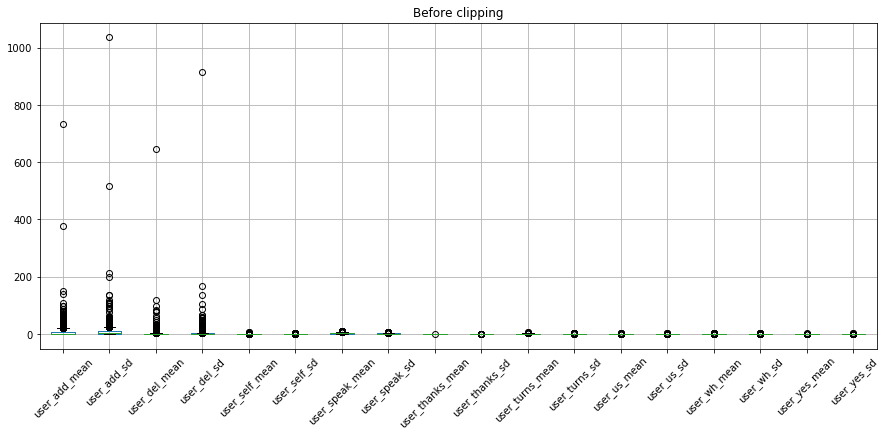

In [6]:
audio_log = features_labels_df[feature_cols]
plt.figure(figsize=(15,6))

audio_log.boxplot()
plt.xticks(rotation=45)
plt.title('Before clipping')

In [5]:
# Feature columns name
# These are the features from audio and logs data used for modeling
feature_cols = ['user_add_mean', 'user_add_sd', 'user_del_mean', 'user_del_sd',
       'user_self_mean', 'user_self_sd', 'user_speak_mean', 'user_speak_sd',
       'user_thanks_mean', 'user_thanks_sd', 'user_turns_mean',
       'user_turns_sd', 'user_us_mean', 'user_us_sd', 'user_wh_mean',
       'user_wh_sd', 'user_yes_mean', 'user_yes_sd'] + ['group']

# These are the contextual features which are used for modeling
context_cols = ['language',
       'learning_design', 'time', 'students', 'class', 'teacher', 'subject']

In [7]:
audio_log = features_labels_df[feature_cols]

In [13]:
# functions to pre-process data

def handleOutliers(df,quantile_range=[.25,.75],plot=False):
    """
    Handling outliers using clipping method.
    """
    # Features with outliers
    df_copy = df.copy()
    if plot:  
        plt.figure(figsize=(15,6))
        df.boxplot()
        plt.xticks(rotation=45)
        plt.title('Before clipping')
        
    outlier_columns = ['user_add_mean','user_add_sd','user_del_mean','user_del_sd']

    for col in outlier_columns:
        col_data = df_copy.loc[:,col]
        quantiles = col_data.quantile(quantile_range)
        clip_col_data = col_data.clip(*quantiles)
        df_copy[col] = clip_col_data
        
    if plot:    
        plt.figure(figsize=(15,6))
        df_copy.boxplot()
        plt.xticks(rotation=45)
        plt.title('After clipping')
    return df_copy
    
    
def applyScaling(df,scaling='Standard'):
    """
    df: dataframe to scale
    scaling: type of scaling to apply
    """
    if not scaling in ['Standard','MaxAbs']:
        print('{} is not recognised. please use one of these: standard, minmax,maxabs'.format(scaling))
        return
    scaler = StandardScaler()
    if scaling == 'MaxAbs':
        scaler = MaxAbsScaler()
    scaled_data = scaler.fit_transform(df)
    
    return pd.DataFrame(scaled_data,columns=df.columns)

def addContextData(df):
    """
    df: dataset
    """
    context_data = pd.read_csv('../CoTrack_dataset_2022_features_v2.csv')
    final_feature_cols = set(feature_cols).intersection(set(df.columns.to_list())) - set(['group'])
    new_df_list = []  
    data_con = pd.get_dummies(context_data[context_cols])  
    context_dummy_cols = data_con.columns
    for group in df.group.unique():
        data_con_grp = data_con.loc[context_data['group'] == group]
        data_fet_grp = df.loc[df['group'] == group]      
        data_con_grp = data_con_grp.reset_index()
        data_con_grp = data_con_grp[data_con_grp.columns.difference(['index'])] 
        res = data_con_grp.iloc[0,:].to_dict()  
        for col in res.keys():
            if col != 'group':
                data_fet_grp[col] = res[col]
        new_df_list.append(data_fet_grp) 
    new_df = pd.concat(new_df_list)  
    total_cols = list(final_feature_cols) + list(context_dummy_cols) 
    final_df = new_df[total_cols]
    return final_df 

## Generating different versions of dataset
Here, we will generate total of 12 datasets.

In [80]:
for index, comb in enumerate(itertools.product(outlier_handle,
                                               scaling,
                                               context_data)):
    
    pipeline = 'dataset_'
    pipeline += 'outlier_handling-' if comb[0] else ''
    pipeline +=  comb[1]
    pipeline += '-with_context_data' if comb[2] else ''
    
    print('Generating dataset:',pipeline)
    pipeline += '.csv'
    result_df = None
    if comb[2]:
        # add context data
        result_df = addContextData(audio_log)
    if comb[0]:
        result_df = handleOutliers(audio_log if result_df is None else result_df)
    result_df = applyScaling(audio_log if result_df is None else result_df,comb[1])
    result_df.to_csv(pipeline,index=False)
    print('Dataset-{:>2} with {}'.format(index+1,pipeline))

Generating dataset: dataset_outlier_handling-Standard-with_context_data
Dataset- 1 with dataset_outlier_handling-Standard-with_context_data.csv
Generating dataset: dataset_outlier_handling-Standard
Dataset- 2 with dataset_outlier_handling-Standard.csv
Generating dataset: dataset_outlier_handling-MaxAbs-with_context_data
Dataset- 3 with dataset_outlier_handling-MaxAbs-with_context_data.csv
Generating dataset: dataset_outlier_handling-MaxAbs
Dataset- 4 with dataset_outlier_handling-MaxAbs.csv
Generating dataset: dataset_Standard-with_context_data
Dataset- 5 with dataset_Standard-with_context_data.csv
Generating dataset: dataset_Standard
Dataset- 6 with dataset_Standard.csv
Generating dataset: dataset_MaxAbs-with_context_data
Dataset- 7 with dataset_MaxAbs-with_context_data.csv
Generating dataset: dataset_MaxAbs
Dataset- 8 with dataset_MaxAbs.csv


## Building Random Forest Classifier and evaluating its generalizablity
We will build random forest classifier for predicting collaboration quality and its dimensions. The developed models will be then evaluated using EFAR-MMLA's framework.

In [9]:
label_cols = ['ARG', 'CF', 'CO', 'CQ', 'ITO', 'KE', 'SMU', 'STR']
def classificationMetrics(y_true,y_pred):
    # add accuracy, precision, recall, kappa, auc, f1-score   
    results = {}    
    results['accuracy'] = accuracy_score(y_true,y_pred)
    results['accuracy2'] = balanced_accuracy_score(y_true,y_pred)
    
    results['precision'] = precision_score(y_true,y_pred)
    results['recall'] = recall_score(y_true,y_pred) 
    results['kappa'] = cohen_kappa_score(y_true,y_pred)
    results['auc'] = roc_auc_score(y_true,y_pred)
    results['f1-score'] = f1_score(y_true,y_pred)    
    return results


def to_labels(pos_probs, threshold):
    """
    This function takes predictor's probabilities and threshold probability. 
    It then transforms probabilities into labels.
    """
    single_probs = pos_probs[:,1]
    
    return (single_probs >= threshold).astype('int')


def selectThreshold(y_prob,y_hat):
    """
    This function select threshold on the basis of max kappa on training data.
    """
    
    prob = np.arange(0,1,.01)   
    mcr = np.zeros(len(prob))
    # computing misclassification rate
    for ind,p in enumerate(prob):
        
        y_pred = to_labels(y_prob,p)
        if len(np.unique(y_pred)) != len(np.unique(y_hat)):
            mcr[ind] = 0
        else:
            mcr[ind] = cohen_kappa_score(y_hat,y_pred)  
        tn, fp, fn, tp = confusion_matrix(y_hat, y_pred).ravel()
    J = np.argmax(mcr)   
    thres = prob[J]
    return thres

In [10]:
def saveResults(table,file):
    df = pd.DataFrame.from_records(table[1:],columns=table[0])
    df.to_csv(file,index=False)
    print('File saved in {}'.format(file))

def assessInstanceContext(pipeline,X,dimensions,tune,threshold,addHeader=False):
    if addHeader:
        report = [['pipeline','target','level','accuracy','accuracy2','precision','recall','kappa','auc','f1-score']]
    else:
        report = []
    metrics = ['accuracy','accuracy2','precision','recall','kappa','auc','f1-score']

    results_array = {}
    results_array_default = {}

    outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
    outer_cv2 = LeaveOneGroupOut()


    max_depth = [3,4,5,6,7]
    n_estimators = [50,100,150,200]

    param_grid = dict(max_depth=max_depth,n_estimators=n_estimators)

    for dim in dimensions:
        dim_label = dim + '_bi'

        for metric in metrics:
            results_array[metric] = []
            results_array_default[metric] = []
        
        for train_index,test_index in outer_cv.split(X):
            X_train = X.loc[train_index,:]
            X_test = X.loc[test_index,:]
    
            y_train = features_labels_df.loc[train_index,dim_label]
            y_test = features_labels_df.loc[test_index,dim_label]
        
            rd = RandomForestClassifier()
    
            if tune:
                grid = GridSearchCV(rd,param_grid,cv=5)
                grid.fit(X_train,y_train)
    
                estimator = grid.best_estimator_
            else:
                estimator = rd
    
            estimator.fit(X_train,y_train)
    
            if threshold:
                y_prob = estimator.predict_proba(X_train)
                thresh = selectThreshold(y_prob,y_train)
                y_pred_proba = estimator.predict_proba(X_test)
                y_pred = to_labels(y_pred_proba,thresh)
                results = classificationMetrics(y_test,y_pred)
            else:
                
                y_pred = estimator.predict(X_test)
                results = classificationMetrics(y_test,y_pred)

            for key,value in results.items():
                results_array[key].append(value)
            
        result_report = [pipeline,dim,'instance']
        for metric in metrics:
            result_report.append('{:.2f}({:.2f})'.format(
                np.mean(results_array[metric]),
                np.std(results_array[metric])
            ))
        report.append(result_report)
        for train_index,test_index in outer_cv2.split(X=X,groups=features_labels_df['session']):
            X_train = X.loc[train_index,:]
            X_test = X.loc[test_index,:]
    
            y_train = features_labels_df.loc[train_index,dim_label]
            y_test = features_labels_df.loc[test_index,dim_label]
        
            rd = RandomForestClassifier()
    
            if tune:
                grid = GridSearchCV(rd,param_grid,cv=5)
                grid.fit(X_train,y_train)  
                estimator = grid.best_estimator_
            else:
                estimator = rd
    
            estimator.fit(X_train,y_train)
    
            if threshold:
                y_prob = estimator.predict_proba(X_train)
                thresh = selectThreshold(y_prob,y_train)
                y_pred_proba = estimator.predict_proba(X_test)
                y_pred = to_labels(y_pred_proba,thresh)
                results = classificationMetrics(y_test,y_pred)
            else:       
                y_pred = estimator.predict(X_test)
                results = classificationMetrics(y_test,y_pred)

            for key,value in results.items():
                results_array[key].append(value)
                
        result_report = [pipeline,dim,'context']
        for metric in metrics:
            result_report.append('{:.2f}({:.2f})'.format(
                np.mean(results_array[metric]),
                np.std(results_array[metric])
            ))
        report.append(result_report)
    return report


In [15]:
#tt = assessInstanceContext(1,applyScaling(audio_log),label_cols,True,False,False)
print(tabulate(tt,headers=['pipeline','target','level','accuracy','accuracy2','precision','recall','kappa','auc','f1-score']))

  pipeline  target    level     accuracy    accuracy2    precision    recall      kappa       auc         f1-score
----------  --------  --------  ----------  -----------  -----------  ----------  ----------  ----------  ----------
         1  ARG       instance  0.64(0.03)  0.63(0.03)   0.63(0.04)   0.79(0.03)  0.27(0.05)  0.63(0.03)  0.70(0.03)
         1  ARG       context   0.58(0.10)  0.60(0.05)   0.60(0.19)   0.78(0.15)  0.18(0.10)  0.60(0.05)  0.64(0.13)
         1  CF        instance  0.74(0.02)  0.59(0.02)   0.75(0.03)   0.94(0.01)  0.22(0.04)  0.59(0.02)  0.84(0.02)
         1  CF        context   0.71(0.15)  0.56(0.05)   0.72(0.16)   0.95(0.04)  0.14(0.11)  0.56(0.05)  0.81(0.12)
         1  CO        instance  0.73(0.02)  0.58(0.02)   0.74(0.03)   0.94(0.02)  0.21(0.05)  0.58(0.02)  0.83(0.02)
         1  CO        context   0.71(0.16)  0.56(0.04)   0.71(0.17)   0.95(0.04)  0.14(0.11)  0.56(0.04)  0.80(0.14)
         1  CQ        instance  0.83(0.02)  0.50(0.00)   0.83(0.02

In [112]:
for index, comb in enumerate(itertools.product(outlier_handle,
                                               scaling,
                                               tuning,
                                               thresholding,
                                               context_data)):
    if index < 24:
        continue
    outlier_config = comb[0]
    scaling_config = comb[1]
    tuning_config = comb[2]
    threshold_config = comb [3]
    context_config = comb[4]

    file_name = ''
    file_name += 'with_context_data-' if comb[4] else ''
    file_name += 'outlier_handling-' if comb[0] else ''
    file_name +=  comb[1]
    file_name += '-hyper_tuning' if comb[2] else ''
    file_name += '-thresholding' if comb[3] else ''
    file_name += '.csv'
    
    data = audio_log.copy()
    
    if context_config:
        data = addContextData(audio_log) 
        
    if outlier_config:
        data = handleOutliers(data)
        
    data = applyScaling(data,scaling_config)
    
    print('Processing: Pipeline ',index+1,file_name)
    tt = assessInstanceContext(index,data,label_cols,tuning_config,threshold_config,True)
    
    saveResults(tt,file_name)

Processing: Pipeline  25 with_context_data-MaxAbs-hyper_tuning-thresholding.csv
File saved in with_context_data-MaxAbs-hyper_tuning-thresholding.csv
Processing: Pipeline  26 MaxAbs-hyper_tuning-thresholding.csv
File saved in MaxAbs-hyper_tuning-thresholding.csv
Processing: Pipeline  27 with_context_data-MaxAbs-hyper_tuning.csv
File saved in with_context_data-MaxAbs-hyper_tuning.csv
Processing: Pipeline  28 MaxAbs-hyper_tuning.csv
File saved in MaxAbs-hyper_tuning.csv
Processing: Pipeline  29 with_context_data-MaxAbs-thresholding.csv
File saved in with_context_data-MaxAbs-thresholding.csv
Processing: Pipeline  30 MaxAbs-thresholding.csv
File saved in MaxAbs-thresholding.csv
Processing: Pipeline  31 with_context_data-MaxAbs.csv
File saved in with_context_data-MaxAbs.csv
Processing: Pipeline  32 MaxAbs.csv
File saved in MaxAbs.csv


In [4]:
# Analyzing reports
re = pd.read_csv('Standard-hyper_tuning.csv')
re.level.unique()

array(['instance', 'context'], dtype=object)

In [12]:
re.loc[re['level']=='context',['pipeline', 'target', 'level', 'accuracy',  'kappa']]

,pipeline,target,level,accuracy,kappa
1,19,ARG,context,0.57(0.11),0.17(0.11)
3,19,CF,context,0.71(0.15),0.14(0.11)
5,19,CO,context,0.70(0.16),0.14(0.10)
7,19,CQ,context,0.82(0.09),0.01(0.03)
9,19,ITO,context,0.64(0.14),0.10(0.10)
11,19,KE,context,0.74(0.11),0.18(0.11)
13,19,SMU,context,0.70(0.14),0.16(0.10)
15,19,STR,context,0.65(0.24),0.07(0.09)


In [9]:
METRICS = ['kappa','auc','accuracy','accuracy2','f1-score']

In [11]:
def getReport(file,dimensions,level,metrics):
    """
    file: result file name
    dimensions: target labels for which to access performance metrics
    level: generalizability levels
    metrics: performance metrics
    
    """
    re = pd.read_csv(file)
    res = {}
    for dim in dimensions:
        
        re_label = re.loc[re['target']==dim,:]
        if isinstance(level,list):
            re_label = re_label.loc[re_label['level'].isin(level),METRICS+['level']]
        else:
            re_label = re_label.loc[re_label['level'] == level,METRICS+['level']]
        re_label.reset_index(inplace=True)
        
        for ind in range(re_label.shape[0]):
            ins_label = re_label.iloc[ind].to_dict()

            key = '{}_{}'.format(dim,ins_label['level'])
            res[key] = ins_label
        
            for metric in METRICS:
                mean_label = '{}_mean'.format(metric)
                std_label = '{}_std'.format(metric)
        
                m,s = getMeanStdFromString(res[key][metric])
        
                res[key][mean_label] = m
                res[key][std_label] = s
    return res

def getMeanStdFromString(rep):
    """
    Function to return mean and std from mean(std) string
    """

    mean = float(rep.split('(')[0])
    std = float(rep.split('(')[1].split(')')[0])
    return mean,std

getReport('Standard-hyper_tuning.csv',['CQ'],'instance',['kappa','auc','accuracy'])        


{'CQ_instance': {'index': 6,
  'kappa': '0.02(0.03)',
  'auc': '0.51(0.01)',
  'accuracy': '0.83(0.02)',
  'accuracy2': '0.51(0.01)',
  'f1-score': '0.91(0.01)',
  'level': 'instance',
  'kappa_mean': 0.02,
  'kappa_std': 0.03,
  'auc_mean': 0.51,
  'auc_std': 0.01,
  'accuracy_mean': 0.83,
  'accuracy_std': 0.02,
  'accuracy2_mean': 0.51,
  'accuracy2_std': 0.01,
  'f1-score_mean': 0.91,
  'f1-score_std': 0.01}}

In [5]:
# Preprocess all results files

TARGETS = ['ARG', 'CF', 'CO', 'CQ', 'ITO', 'KE', 'SMU', 'STR']

final_report = pd.DataFrame(columns=['pipeline','report_file','target','level',
                                     'kappa_mean','kappa_std',
                                    'auc_mean','auc_std',
                                    'accuracy_mean','accuracy_std',
                                    'f1-score_mean','f1-score_std'])

In [7]:

def getTopNPipelines(files,dimensions,sort_metric,level,n):
    cols = ['file','target','level']
    
    for metric in METRICS:
        mean_label = '{}_mean'.format(metric)
        std_label = '{}_std'.format(metric)
        cols.append(mean_label)
        cols.append(std_label)
    
    df = pd.DataFrame(columns=cols)
    
    for file in files:
        report = getReport(file,dimensions,level,[metric])
        
        for key,value in report.items():
            record = {'file':file,'target':key.split('_')[0],'level':key.split('_')[1]}
            
            for metric in METRICS:
                mean_label = '{}_mean'.format(metric)
                std_label = '{}_std'.format(metric) 
                
                record[mean_label] = value[mean_label]
                record[std_label] = value[std_label]
                
            df = df.append(record,ignore_index=True)
    
    metric_mean = sort_metric +'_mean'
    metric_std = sort_metric+'_std'   
    top_df = df.sort_values(by=metric_mean,ascending=False)
    
    return top_df.head(n), top_df, top_df.loc[top_df['file'] == 'Standard-hyper-tuning.csv',:]

## Performance comparison

In [ ]:
files = []


for index, comb in enumerate(itertools.product(outlier_handle,
                                               scaling,
                                               tuning,
                                               thresholding,
                                               context_data)):
    file_name = ''
    file_name += 'with_context_data-' if comb[4] else ''
    file_name += 'outlier_handling-' if comb[0] else ''
    file_name +=  comb[1]
    file_name += '-hyper_tuning' if comb[2] else ''
    file_name += '-thresholding' if comb[3] else ''
    file_name += '.csv'
    
    files.append(file_name)

    
for dim in TARGETS:
    top,all_pipes,base = getTopNPipelines(files,[dim],'kappa','context',10)
    print('Top pipelines for {} are as follows'.format(dim))
    pipes = top['file'].to_list()
    kappa = top['kappa_mean'].to_list()
    kappa_std = top['kappa_std'].to_list()
    
    acc = top['accuracy_mean'].to_list()
    acc_std = top['accuracy_std'].to_list()
    
    print('\n\t','\n\t '.join(pipes))
    print(kappa)
    print(kappa_std)
    print(acc)
    print(acc_std)
    print('\t Lowest:',all_pipes.iloc[-1]['file'])
    print('\t Base:',base.loc[:,['kappa_mean','kappa_std']].to_dict())
    print('\n')


In [ ]:
files = []
for index, comb in enumerate(itertools.product(outlier_handle,
                                               scaling,
                                               tuning,
                                               thresholding,
                                               context_data)):
    file_name = ''
    file_name += 'with_context_data-' if comb[4] else ''
    file_name += 'outlier_handling-' if comb[0] else ''
    file_name +=  comb[1]
    file_name += '-hyper_tuning' if comb[2] else ''
    file_name += '-thresholding' if comb[3] else ''
    file_name += '.csv'
    
    files.append(file_name)

    
for dim in TARGETS:
    top,all_pipes,base = getTopNPipelines(files,[dim],'kappa','instance',10)
    print('Top pipelines for {} are as follows'.format(dim))
    pipes = top['file'].to_list()
    kappa = top['kappa_mean'].to_list()
    kappa_std = top['kappa_std'].to_list()
    
    acc = top['accuracy_mean'].to_list()
    acc_std = top['accuracy_std'].to_list()
    
    print('\n\t','\n\t '.join(pipes))
    print(kappa)
    print(kappa_std)
    print(acc)
    print(acc_std)
    print('\t Lowest:',all_pipes.iloc[-1]['file'])
    print('\t Base:',base.loc[:,['kappa_mean','kappa_std']].to_dict())
    print('\n')

### Findings
1. Adding context data improves generalizablity of models in classifying collaboration quality
2. Performance metric for MMLA and skewed data should take into account both classes. Thus following could be used:
    Kappa, AUC, Balanced Accuracy

## Statistical test

In [ ]:

def getKappaForComb(config_list,level,dim='CQ'):
    DIM =  dim
    
    kappa = []
    for index, comb in enumerate(itertools.product(*config_list)):
        file_name = ''
        file_name += 'with_context_data-' if comb[4] else ''
        file_name += 'outlier_handling-' if comb[0] else ''
        file_name +=  comb[1]
        file_name += '-hyper_tuning' if comb[2] else ''
        file_name += '-thresholding' if comb[3] else ''
        file_name += '.csv'
        
        pipe = ''
        pipe += 'CON->' if comb[4] else ''
        pipe += 'OH->' if comb[0] else ''
        pipe +=  comb[1][:3]
        pipe += '->HP' if comb[2] else ''
        pipe += '->TH' if comb[3] else ''
    
        
        
        res = getReport(file_name,[DIM],level,['kappa_mean'])
        kappa.append(res['{}_{}'.format(DIM,level)]['kappa_mean'])
        #print('   ',pipe)
    return kappa



org_config = {'outlier_config':outlier_handle,
         'scaling_config':scaling,
         'tuning_config':tuning,
         'thresholding_config':thresholding,
         'context_config':context_data}

report = [['variable','t-value','p_value (diff=0)','p_value (diff<0)','p_value (diff>0)']]

for conf in org_config.keys():
    print(' ',conf,'============>',mean_diff)
    effect_col = conf.split('_')[0]
    record = [effect_col]
    
    temp_config = org_config.copy()
    if conf == 'scaling_config':
        temp_config[conf] = ['Standard']
    else:
        temp_config[conf] = [True]
        
    with_col = []    
    without_col = []
    
    for label in TARGETS:
        with_col += getKappaForComb(list(temp_config.values()),'context',label)
    
    temp_config = org_config.copy()
    if conf == 'scaling_config':
        temp_config[conf] = ['MaxAbs']
    else:
        temp_config[conf] = [False]
        
    for label in TARGETS:
        without_col += getKappaForComb(list(temp_config.values()),'context',label)
    #plt.figure()
    #sns.distplot(with_col)
    
    #plt.figure()
    #sns.displot(without_col)
    
    #print(' ',with_col,'\n ',without_col)
    df = pd.DataFrame({'with':with_col,'without':without_col})
    
    desc, res = researchpy.ttest(df['with'],df['without'],paired=True, equal_variances = False)
    #print(np.mean(with_col),np.mean(without_col))
    print(res)
    
    #t_value,p_value=stats.ttest_rel(with_col,without_col)
    w=stats.wilcoxon(with_col,without_col)

    
    
    
    mean_diff = np.array([ a - b for a,b in zip(with_col,without_col)]).mean()

    
    

   
    record.append(w.statistic)
    record.append(w.pvalue)
    w=stats.wilcoxon(with_col,without_col,alternative="less")
    
    record.append(w.pvalue)
    
    w=stats.wilcoxon(with_col,without_col,alternative="greater")
   
    record.append(w.pvalue)
    
    report.append(record)
    
print(tabulate(report,headers='firstrow'))
    
print('=='*20)
